In [2]:
import cv2
import numpy as np
from scipy.spatial.distance import cosine
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
import os
from tqdm.auto import tqdm

In [ ]:


# 이미지 파일들이 저장된 폴더 경로
folder_path = r'C:\Users\NTX550\Desktop\MUSINSA-1\JK\merged_image'

# 이미지 파일들의 목록 가져오기
image_files = os.listdir(folder_path)

# VGG16 모델 로드
vgg_model = VGG16(weights='imagenet', include_top=False)

# 특성 벡터를 저장할 리스트 초기화
all_vgg_features = []
all_histograms = []
all_hue_features = []

# 이미지들에 대해 반복하여 특성 추출
for i in tqdm(range(0,10000)):
    try:
        # 이미지 파일 경로
        image_path = os.path.join(folder_path, image_files[i])
        
        # 이미지 로드 및 전처리
        img = load_img(image_path, target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # VGG16 특성 추출
        vgg_features = vgg_model.predict(x)
        vgg_features = np.squeeze(vgg_features)
        all_vgg_features.append(vgg_features)

        # 색상 히스토그램 계산
        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        histogram = cv2.calcHist([image_rgb], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        all_histograms.append(histogram)

        # 색조(Hue) 특성 추출
        image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
        hue_channel = image_hsv[:, :, 0]
        hue_features = np.histogram(hue_channel, bins=8, range=(0, 180))[0]
        all_hue_features.append(hue_features)
    
    except cv2.error as e:
        if str(e) == '(-215:Assertion failed) !_src.empty() in function \'cv::cvtColor\'':
            # _src.empty() 조건이 만족되지 않은 경우에만 실행
            pass

# 특성 벡터들을 저장
np.save('saved_vgg_features.npy', np.array(all_vgg_features))
np.save('saved_histograms.npy', np.array(all_histograms))
np.save('saved_hue_features.npy', np.array(all_hue_features))


In [7]:
# 특성 벡터들을 저장
np.save('saved_vgg_features.npy', np.array(all_vgg_features))
np.save('saved_histograms.npy', np.array(all_histograms))
np.save('saved_hue_features.npy', np.array(all_hue_features))

In [67]:
# 이미지 파일 경로
image_path = r'c:\Users\NTX550\Downloads\2928418_36357327_0.jpg'

# VGG16 모델 로드
vgg_model = VGG16(weights='imagenet', include_top=False)

# 이미지 로드 및 전처리
img = load_img(image_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# VGG16 특성 추출
vgg_features = vgg_model.predict(x)
vgg_features = np.squeeze(vgg_features)

# 색상 히스토그램 계산
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
histogram = cv2.calcHist([image_rgb], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

# 색조(Hue) 특성 추출
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
hue_channel = image_hsv[:, :, 0]
hue_features = np.histogram(hue_channel, bins=8, range=(0, 180))[0]

# 저장된 특성 벡터 로드
saved_vgg_features = np.load('saved_vgg_features.npy')
saved_histograms = np.load('saved_histograms.npy')
saved_hue_features = np.load('saved_hue_features.npy')

# 유사도 측정을 위한 비교
vgg_similarities = []
histogram_similarities = []
hue_similarities = []

for vgg_feature in saved_vgg_features:
    vgg_similarity = 1 - cosine(vgg_feature.flatten(), vgg_features.flatten())
    vgg_similarities.append(vgg_similarity)

for saved_histogram in saved_histograms:
    histogram_similarity = cv2.compareHist(saved_histogram, histogram, cv2.HISTCMP_CORREL)
    histogram_similarities.append(histogram_similarity)

for saved_hue_feature in saved_hue_features:
    hue_similarity = 1 - cosine(saved_hue_feature, hue_features)
    hue_similarities.append(hue_similarity)

vgg_similarities_array = np.array(vgg_similarities)
# 종합 유사도 계산
weights = [5, 3, 2]  # 가중치 설정 average의 weights에는 소수 비율 안됨
# weights = np.array([5, 3, 2], dtype=np.float32) 
similarities = np.average([(vgg_similarities[:5465]), np.array(histogram_similarities), np.array(hue_similarities)], axis=0, weights=weights)

# 유사도가 가장 높은 상위 N개의 인덱스 가져오기
top_indices = np.argsort(similarities)[::-1][:30]

# 유사한 이미지 파일 목록 가져오기
similar_image_files = [image_files[i] for i in top_indices]

# 결과 출력
print("Most similar images:")
for image_file in similar_image_files:
    print(image_file)


1/1 [==============================] - 1s 920ms/step
Most similar images:
1505321_4.jpg
1505321_3.jpg
1505321_5.jpg
1505321_2.jpg
1595690_1.jpg
1609341_0.jpg
1619420_1.jpg
1558846_0.jpg
1581943_1.jpg
1563622_0.jpg
1620268_6.jpg
1619424_1.jpg
1557824_1.jpg
1582211_1.jpg
1571143_0.jpg
1542823_3.jpg
1620288_6.jpg
1558846_6.jpg
1532828_2.jpg
1558846_4.jpg
1515894_3.jpg
1446486_1.jpg
1582065_1.jpg
1542847_3.jpg
1564613_0.jpg
1582065_2.jpg
1446486_0.jpg
1575855_1.jpg
1558846_3.jpg
1620288_4.jpg


In [62]:
print("Most similar images:")
for image_file in similarities:
    print(image_file)

Most similar images:
0.08289569883923828
0.07456989877748517
0.05642453004971223
0.0595817798020644
0.2501673366263528
0.27256814813880503
0.22010986303668517
0.20575615048363524
0.1836677177066972
0.16430013877464728
0.20135046899797082
0.21622858599736355
0.18208099657679486
0.16345363674102487
0.15001369822625188
0.16385229445436528
0.15703119831595838
0.15533231262643862
0.10378937386754632
0.09922775882524978
0.06632663920664147
0.13267073647501984
0.12371812057213796
0.0620918880796532
0.048581617495080866
0.04446585204505895
0.16620653027868387
0.1787017272631498
0.11852724788830982
0.10572378410334934
0.07407399910701906
0.15314907755551865
0.1439855566497207
0.08946861433923467
0.07890424941613347
0.04103656980271028
0.275797377067153
0.2492512741340991
0.22701145042053975
0.15814651520691272
0.18101739139296308
0.12679962818178972
0.15598030263540408
0.1058264599891984
0.10597387627826534
0.07654430671130467
0.12025670562026396
0.1437209240620595
0.0699797117260734
0.05405148

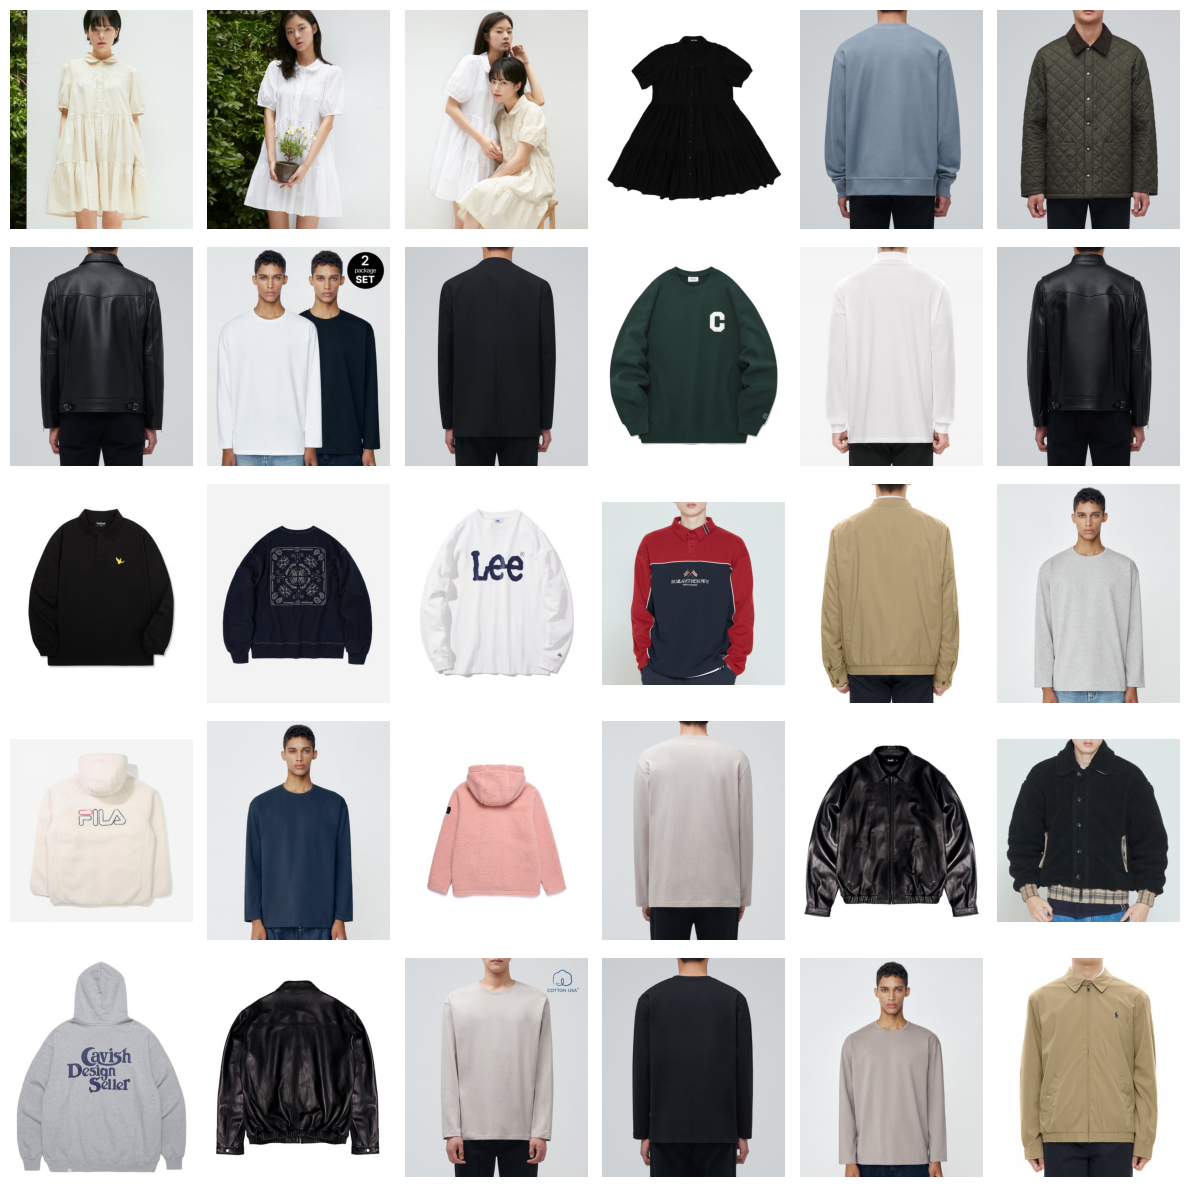

In [68]:
import matplotlib.pyplot as plt
from PIL import Image

# ...

# Similar images to display
similar_images = similar_image_files[:30]

# Create a 6 by 5 subplot grid
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

# Iterate over the similar images and display them
for i in range(len(similar_images)):
    image_path = r'C:\Users\NTX550\Desktop\MUSINSA-1\JK\merged_image' + '/' + similar_images[i]
    # Load the image
    image = Image.open(image_path)

    # Calculate the subplot position
    row = i // 6
    col = i % 6

    # Display the image in the corresponding subplot
    axs[row, col].imshow(image)
    axs[row, col].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
